In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
import os

C:\Users\bhanu\AppData\Local\Temp\ipykernel_10844\3906708540.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'data'
image_exts = ['jpg','jpeg','bmp','png']

In [5]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [6]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 823 files belonging to 2 classes.


In [7]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

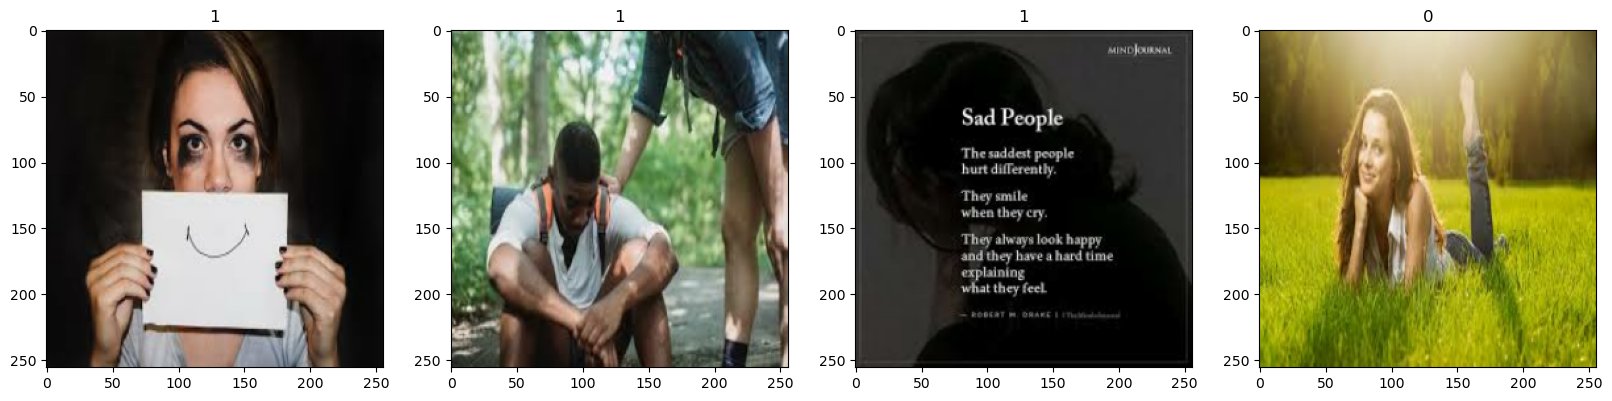

In [18]:
fig,ax = plt.subplots(nrows = 1,ncols =4,figsize=(20,10))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [19]:
data = data.map(lambda x,y : (x/255,y))

In [20]:
scaled_iterator = data.as_numpy_iterator()

In [21]:
batch = scaled_iterator.next()

In [22]:
batch[0].max()

1.0

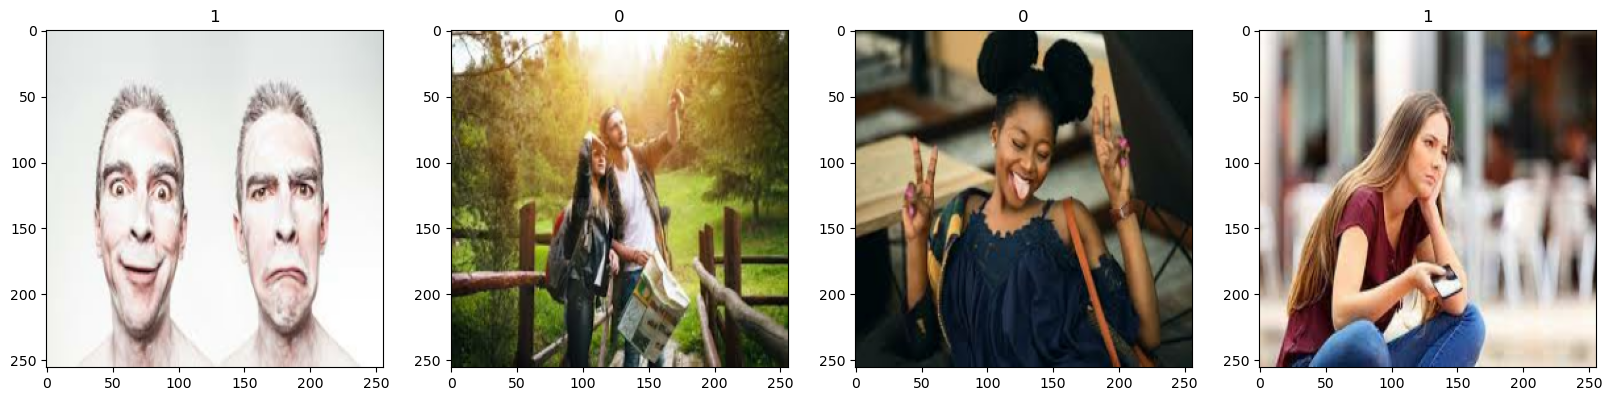

In [27]:
fig,ax = plt.subplots(nrows = 1,ncols = 4,figsize=(20,10))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

In [35]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)+1
test_size=int(len(data)*0.1)

In [36]:
val_size

6

In [37]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

In [41]:
model = Sequential()
model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics =['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)       

In [43]:
logdir ='logs'

In [44]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [45]:
hist = model.fit(train,epochs = 30,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/30
18/18 [==============================] - 48s 2s/step - loss: 0.6933 - accuracy: 0.5278 - val_loss: 0.6767 - val_accuracy: 0.6667
Epoch 2/30
18/18 [==============================] - 43s 2s/step - loss: 0.6288 - accuracy: 0.6510 - val_loss: 0.6114 - val_accuracy: 0.6302
Epoch 3/30
18/18 [==============================] - 42s 2s/step - loss: 0.6009 - accuracy: 0.6823 - val_loss: 0.5563 - val_accuracy: 0.7396
Epoch 4/30
18/18 [==============================] - 43s 2s/step - loss: 0.5713 - accuracy: 0.7309 - val_loss: 0.5116 - val_accuracy: 0.7969
Epoch 5/30
18/18 [==============================] - 43s 2s/step - loss: 0.5240 - accuracy: 0.7639 - val_loss: 0.4880 - val_accuracy: 0.7917
Epoch 6/30
18/18 [==============================] - 43s 2s/step - loss: 0.5135 - accuracy: 0.7552 - val_loss: 0.4426 - val_accuracy: 0.8073
Epoch 7/30
18/18 [==============================] - 44s 2s/step - loss: 0.4648 - accuracy: 0.8003 - val_loss: 0.5271 - val_accuracy: 0.7656
Epoch 8/30
18/18 [==

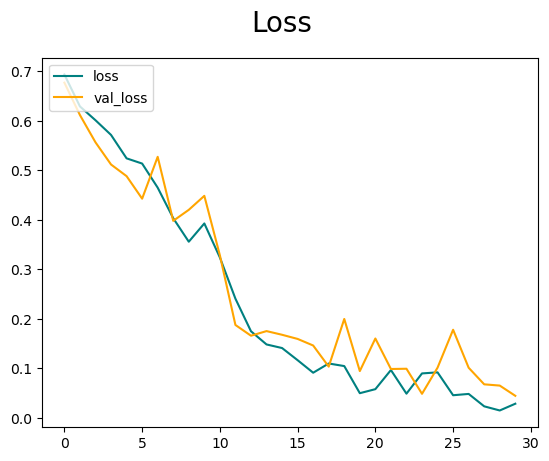

In [46]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
plt.suptitle('Loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

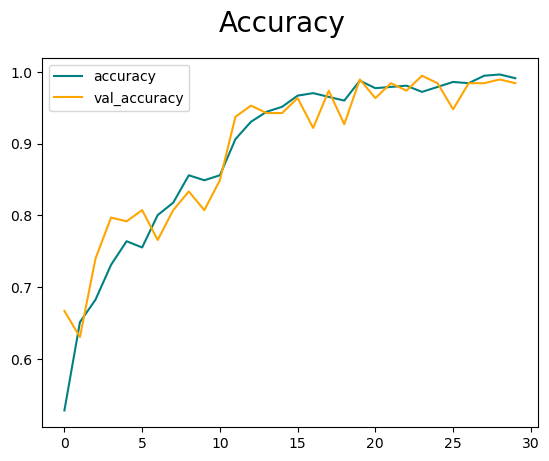

In [47]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
plt.suptitle('Accuracy',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [48]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [50]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [51]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 1s 563ms/step


In [53]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:0.95652174949646,Recall:1.0,Accuracy:0.9818181991577148


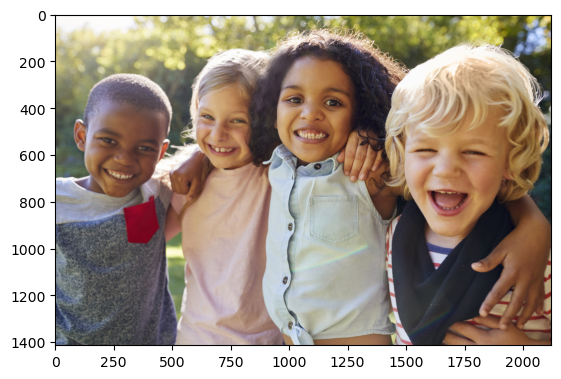

In [72]:
img = cv2.imread('l2.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

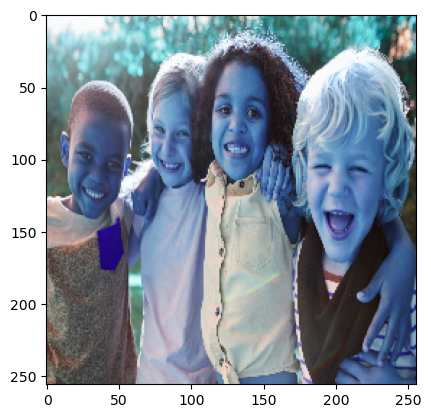

In [73]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [74]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 58ms/step


In [75]:
yhat

array([[0.43684334]], dtype=float32)

In [76]:
from tensorflow.keras.models import load_model

In [77]:
model.save(os.path.join('models','happysadmodel.h5'))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
